In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import prologuefunctions as prologue #Library for loading data
from IPython.core.debugger import set_trace
from torch import optim
from torch import Tensor
import matplotlib.pyplot as plt

# Load Data

In [2]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

Using downloaded and verified file: ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw
Using downloaded and verified file: ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Using downloaded and verified file: ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw
Using downloaded and verified file: ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


# Data Preprocess

In [44]:
train_input_centered = train_input - train_input.mean(0)
print(train_input.narrow(0,0,100).size()) 

torch.Size([100, 2, 14, 14])


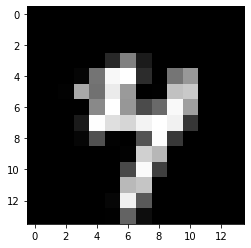

In [51]:
plt.imshow(train_input[7,0], cmap="gray")
plt.show()

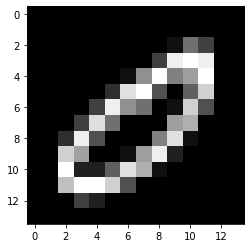

In [52]:
plt.imshow(train_input[7,1], cmap="gray")
plt.show()


# Constructing NN

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 16, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(128, 100)
        self.out1 = nn.Linear(100, 20)
        
        self.fc2 = nn.Sequential(nn.Dropout2d(p=0.4), nn.Linear(100,100))
        self.out2 = nn.Linear(100, 2)
        
    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = self.bn2(x)
        
        x = F.relu(self.fc1(x.view(-1, 128)))
        y = self.out1(x)
        y = y.view(-1,2,10)
        
        x = F.relu(self.fc2(x))
    
        x = self.out2(x)
        
        return x, y



In [5]:
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 16, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(128, 100)
        self.out1 = nn.Linear(100, 10)
        self.out2 = nn.Linear(100,10)
        
        self.fc2 = nn.Sequential(nn.Dropout2d(p=0.4), nn.Linear(100,100))
        self.out = nn.Linear(100, 2)
        
    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = self.bn2(x)
        
        x = F.relu(self.fc1(x.view(-1, 128)))
        y = self.out1(x)
        
        
        z = self.out2(x)
        
        
        x = F.relu(self.fc2(x))
    
        x = self.out(x)
        
        return x, y, z 



In [6]:
class ResBlock(nn.Module):
    def __init__(self, input_channels, channels, stride = 1,dim_change = None):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(channels)
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(channels)
        
        self.dim_change = dim_change
        
    def forward(self,x):
        
        res = x
        
        y = F.relu(self.bn1(self.conv1(x)))
      
        y = self.bn2(self.conv2(y))
        
        if self.dim_change is not None:
            res = self.dim_change(res)
        y += res
        y = F.relu(y)
        
        return y
    

In [54]:

class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet,self).__init__()
        
        self.input_channels = 16
        self.conv1 = nn.Conv2d(2, 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.drop1 = nn.Dropout2d(p = 0.6)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.avg_pool = nn.AvgPool2d(7)
        
        self.drop2 = nn.Dropout2d(p=0.6)
        self.fc1 = nn.Linear(32,100)
        self.out1 = nn.Linear(100,20)
        
        self.drop3 = nn.Dropout2d(p = 0.6)
        self.fc2 = nn.Linear(100, 100)
        self.out2 = nn.Linear(100,2)
        
        
        
    def make_layer(self, block, out_channels, blocks, stride = 1):
        dim_change = None
        if (self.input_channels == out_channels) or (stride !=1):
            dim_change = nn.Sequential(nn.Conv2d(self.input_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.input_channels, out_channels, stride,dim_change))
        self.input_channels = out_channels
        for i in range(1,blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = self.drop2(x)
        x = F.relu(self.fc1(x.view(-1,32)))
        y = self.out1(x)
        y = y.view(-1,2,10)
        x = self.drop3(x)
        x = F.relu(self.fc2(x))
        x = self.out2(x)
        
        return x,y
        
        
        

# Training NN

- Batch
- number epochs
- learning rate


In [10]:
def training_model(train_input, train_target, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output = model(train_input.narrow(0, b, batch))            
        loss = criterion(output, train_target.narrow(0, b, batch))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [11]:
def compute_nb_errors(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output = model(data_input.narrow(0, b, batch))
        _, predicted_classes = torch.max(output, 1)
        for k in range(batch):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [41]:
def training_aux(train_input, train_target, train_classes, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    Binary_Criterion = nn.CrossEntropyLoss()
    Aux_Criterion = nn.CrossEntropyLoss()
    total_loss_aux = 0
    total_loss_bin = 0
    final_total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output, aux = model(train_input.narrow(0, b, batch))
        target_classes = train_classes.narrow(0, b, batch)
        target_comparison = train_target.narrow(0, b, batch)
        aux_loss = Aux_Criterion(aux[:,0], target_classes[:,0]) + Aux_Criterion(aux[:,0], target_classes[:,1])
        binary_loss = Binary_Criterion(output, target_comparison)
        final_loss = 0.7*binary_loss + 0.3*aux_loss
        model.zero_grad()
        final_loss.backward()
        optimizer.step()
        total_loss_aux += aux_loss
        total_loss_bin += binary_loss
        final_total_loss += final_loss
    return final_total_loss, total_loss_aux, total_loss_bin
    
    

In [32]:
def compute_nb_errors_aux(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output,_ = model(data_input.narrow(0, b, batch))
        _, predicted_classes = torch.max(output, 1)
        for k in range(batch):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [14]:
def training_aux2(train_input, train_target, train_classes, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    Binary_Criterion = nn.CrossEntropyLoss()
    Aux_Criterion = nn.CrossEntropyLoss()
    total_loss_aux = 0
    total_loss_bin = 0
    final_total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output, aux1, aux2 = model(train_input.narrow(0, b, batch))
        target_classes = train_classes.narrow(0, b, batch)
        target_comparison = train_target.narrow(0, b, batch)
        aux_loss = Aux_Criterion(aux1, target_classes[:,0]) + Aux_Criterion(aux2, target_classes[:,1])
        binary_loss = Binary_Criterion(output, target_comparison)
        final_loss = 0.9*binary_loss + 0.1*aux_loss
        model.zero_grad()
        final_loss.backward()
        optimizer.step()
        total_loss_aux += aux_loss
        total_loss_bin += binary_loss
        final_total_loss += final_loss
    return final_total_loss, total_loss_aux, total_loss_bin
    

In [22]:
epochs = 100
losses = torch.zeros((3, epochs))
model = Net()
for e in range(epochs):
    training_aux(train_input, train_target, train_classes, model , 100, 0.05)
    print(compute_nb_errors_aux(model, train_input,train_target, 100), " ",compute_nb_errors_aux(model, test_input,test_target, 100))



ValueError: not enough values to unpack (expected 3, got 2)

In [57]:
epochs = 600
losses = torch.zeros((3, epochs))

net_args = {
    "block": ResBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)
print(model)


ResNet(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.5, inplace=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dim_change): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
for e in range(epochs):
    model.train
    training_aux(train_input, train_target, train_classes, model , 100, 0.04)
    model.eval
    print(compute_nb_errors_aux(model, train_input,train_target, 100), " ",compute_nb_errors_aux(model, test_input,test_target, 100))




14   257
16   218
6   253
18   239
9   239
7   267
13   242
12   252
13   245
13   265
10   231
15   256
10   254
11   265
7   247
9   264
18   245
11   272
13   255
10   251
15   232
13   232
11   255
4   233
12   252
17   248
10   247
13   240
7   258
10   233
19   248
9   240
11   223
15   247
18   250
11   243
5   246
7   252
19   259
15   251
19   243
14   252
7   248
12   234
18   255
15   262
9   242
11   245
10   249
